<a href="https://colab.research.google.com/github/wenjie-hoo/baltic_ml/blob/main/baltic_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pandas.plotting import scatter_matrix
from zipfile import ZipFile
from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import column_or_1d

warnings.filterwarnings('ignore')


#### Here we are focusing on agricultural pollution and industrial residue in the Baltic Sea

A significant problem in the Baltic sea is eutrophication which leads to cloudy water, reducing light conditions in the water and oxygen consumption. The excessive richness of nutrition in water is caused mainly by agricultural pollution and industrial residue. 

|  element  | short-form |
|  ----  | ----  |
|Dissolved oxygen |  OXY|
|Phosphate | PO4|
|Total phosphorus | TP|
|Nitrogen dioxide | NO2|
|Nitrate | NO3|
|Ammonia | NH4|
|Total nitrogen | TN|
|Silicon dioxide | SIO2|
|Chlorophyll | CHLORA|
|Secchi depth | SECCHI|
|Dissolved Inorganic Carbon (DIC) | PH|
|Salinity | CTDSAL|
|Centigrade Temperature | CTDTMP|

In [2]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

Downloading...
From: https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip
To: /content/2022.11.07-merged-single-observation.zip
100% 329k/329k [00:00<00:00, 16.5MB/s]


In [3]:
# load data to data frame
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')

In [4]:
# check missing values
df_missing = df.drop(['DATE'],axis=1)
missing = df_missing.isna().sum()
missing = pd.DataFrame(data={'elements': missing.index,'missing':missing.values})
missing = missing[~missing['missing'].isin([0])]
missing['percentage'] =  missing['missing']/df_missing.shape[0]
missing.sort_values(by='percentage',ascending=False)


,elements,missing,percentage
8,PH,4011,0.841233
12,TN,2167,0.454488
5,NO2,2062,0.432466
4,NH4,1998,0.419044
11,SIO2,1920,0.402685
6,NO3,1886,0.395554
10,SECCHI,1796,0.376678
1,CHLORA,1773,0.371854
9,PO4,1202,0.252097
13,TP,801,0.167995


In [5]:
# check df data type
df_missing[missing['elements']].info()
df_missing = df_missing.drop(['DEPTH'],axis=1)
df_missing = df_missing.drop(['PH'],axis=1) # PH has too many missing values


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 0 to 4767
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CHLORA  2995 non-null   float64
 1   CTDSAL  4510 non-null   float64
 2   CTDTMP  4574 non-null   float64
 3   NH4     2770 non-null   float64
 4   NO2     2706 non-null   float64
 5   NO3     2882 non-null   float64
 6   OXY     4406 non-null   float64
 7   PH      757 non-null    float64
 8   PO4     3566 non-null   float64
 9   SECCHI  2972 non-null   float64
 10  SIO2    2848 non-null   float64
 11  TN      2601 non-null   float64
 12  TP      3967 non-null   float64
dtypes: float64(13)
memory usage: 521.5 KB


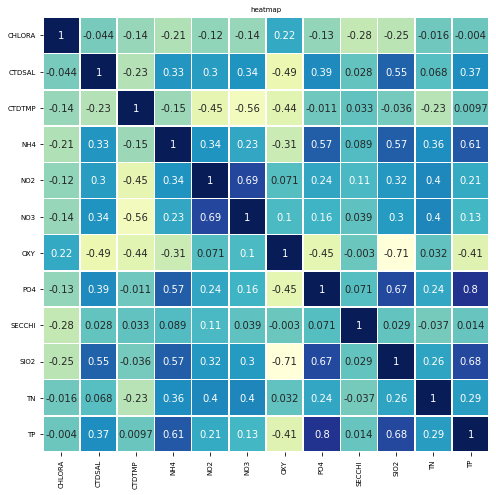

In [6]:
# heatmap
fig = plt.figure(figsize=(8,8))
sns.heatmap(df_missing.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('heatmap',fontsize=7)
plt.show()

In [7]:
X_missing = df_missing.copy()
y_missing = df_missing.copy()
y_missing.dropna(inplace=True) 
X_missing = pd.DataFrame(X_missing)
y_missing = pd.DataFrame(y_missing)

In [8]:
# fill missing values with random forest regression 
X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values #sort missing columns

for i in sortindex:
    df_ = X_missing_reg  
    fillc = df_.iloc[:, i]  
    df_ = pd.concat([df_.drop(df_.columns[i], axis=1), pd.DataFrame(y_missing)], axis=1)
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df_)
    #train and test dataset
    Ytrain = fillc[fillc.notnull()]  # not missing part is Y_train
    Ytest = fillc[fillc.isnull()] 
    Xtrain = df_0[Ytrain.index, :]
    Xtest = df_0[Ytest.index, :] 
    rfc = RandomForestRegressor(n_estimators=100) 
    rfc = rfc.fit(Xtrain, Ytrain)  
    Ypredict = rfc.predict(Xtest)
    # put prediction values back to df
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), X_missing_reg.columns[i]] = Ypredict

X_missing_reg.isna().sum()


CHLORA    0
CTDSAL    0
CTDTMP    0
NH4       0
NO2       0
NO3       0
OXY       0
PO4       0
SECCHI    0
SIO2      0
TN        0
TP        0
dtype: int64

In [9]:
X_missing_reg.insert(0,column = 'DATE',value=df['DATE'])
X_missing_reg.insert(1,column = 'DEPTH',value=df['DEPTH'])
X_missing_reg = X_missing_reg[pd.notnull(X_missing_reg['DATE'])]
# X_missing_reg = X_missing_reg.sort_values(by='DATE')

In [10]:
# counting depth
print(df['DEPTH'].value_counts())
depth_list = (df['DEPTH'].value_counts()[df['DEPTH'].value_counts() > 400]).index.to_list()
depth_list.sort()
print(depth_list)

100     739
2000    734
1000    733
500     732
1500    732
2500    454
2600    276
200     102
300      95
2700     50
0        22
2400     13
1700      8
2800      8
1400      8
900       8
1300      8
1900      6
1200      5
400       4
2100      4
2300      3
2200      3
1100      3
800       3
1800      3
509       2
700       2
3500      1
1510      1
110       1
1010      1
2900      1
2750      1
2640      1
1450      1
Name: DEPTH, dtype: int64
[100, 500, 1000, 1500, 2000, 2500]


In [11]:
# create df by depth
def filter_by_depth(df, depth):
    df = df.loc[df['DEPTH'] == depth]
    return df

def get_depth_list(df):
    df_depth_list = []
    for i in depth_list:
        df_name = 'df_depth_' + str(i)
        vars()[df_name] = filter_by_depth(df,i)
        df_depth_list.append(df_name)
    return df_depth_list
    

df_depth_list = []
for i in depth_list:
    df_name = 'df_depth_' + str(i)
    vars()[df_name] = filter_by_depth(X_missing_reg,i)
    df_depth_list.append(df_name)
df_depth_list

['df_depth_100',
 'df_depth_500',
 'df_depth_1000',
 'df_depth_1500',
 'df_depth_2000',
 'df_depth_2500']

### Examples of physical and chemical water quality indicators include:
nutrients (e.g. nitrogen, phosphorus) \
microalgal growth (e.g. chlorophyll-a) \
water clarity (e.g. turbidity, suspended solids, Secchi depth)\
pH\
dissolved oxygen\
temperature\
salinity\
metals (e.g. lead, copper)\
pesticides.

#### Created simple parameter : 0.4*OXY + 0.3*SECCHI + 0.3*CHLORA measuring water quality and tried predicting it on models provided at models.ipynb with some small modifications, using elements from fertilizers and silicate as X
#### works ok mostly based on silicates,  but other matters too r2_score better at greater depths

In [12]:
def get_splitted_dataset(df):
    X_cols = ['TP', 'TN', 'NO3','PO4', 'NH4', 'SIO2','CTDTMP','CTDSAL']
    df['quality'] = 0.4*df['OXY'] + 0.3*df['SECCHI'] + 0.3*df['CHLORA']
    y_col = ['quality']
    X = df[X_cols]
    y = df[y_col]
    y = column_or_1d(y, warn=True)  
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true  ) ) ) * 100

In [15]:
# Depth 100 as dataset
x_train, x_test, y_train, y_test = get_splitted_dataset(df_depth_100)

In [16]:
# linear regression
lg = LinearRegression()
lg.fit(x_train, y_train)
y_pred_lr = lg.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lr))
print('MAE:',mean_absolute_error(y_test,y_pred_lr))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_lr))

MSE: 139.4882044373566
MAE: 7.5321788946954396
MAPE: 5.781372937471865


In [17]:
# Gradient boosting regression
bg = GradientBoostingRegressor()
bg.fit(x_train, y_train)
y_pred_gbr = bg.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_gbr))
print('MAE:',mean_absolute_error(y_test,y_pred_gbr))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_gbr))


MSE: 108.66257489982921
MAE: 7.151570045536419
MAPE: 5.488095103308355


In [18]:
# neural network
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(x_train,y_train)
y_pred_mlp = mlp.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_mlp))
print('MAE:',mean_absolute_error(y_test,y_pred_mlp))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_mlp))


MSE: 457.10971006798576
MAE: 17.465444482269607
MAPE: 13.597836120046214


In [19]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)
y_pred_rf = rfr.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_rf))
print('MAE:',mean_absolute_error(y_test,y_pred_rf))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_rf))

#####################

def rfr_pre(x_train,x_test,y_train,y_test):
    rfr = RandomForestRegressor(random_state=0)
    rfr.fit(x_train, y_train)
    y_pred_rf = rfr.predict(x_test)
    return y_pred_rf

MSE: 103.98434345925374
MAE: 6.823649973499826
MAPE: 5.315574463393135


1 CTDTMP 0.6492088164489206
2 SIO2 0.1461256203429672
3 CTDSAL 0.06074009563887164
4 TN 0.037301094969369404
5 PO4 0.03546404616846256
6 NH4 0.029212123662393848
7 TP 0.024074371661718472


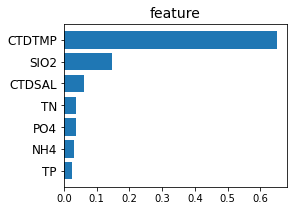

In [20]:
def plot_feature(df,x_train):
    feat_lebels = x_train.columns[0:]
    importances  = rfr.feature_importances_
    indices = np.argsort(importances)[::-1]
    index_list = []
    value_list = []
    for i,j in zip(range(x_train.shape[1]-1),indices):
        index_list.append(feat_lebels[j])
        value_list.append(importances[j])
        # print(i+1, feat_lebels[j], importances[j])

    plt.figure(figsize=(4,3))
    plt.barh(index_list[::-1],value_list[::-1])
    plt.yticks(fontsize = 12)
    plt.title(df+' '+'feature',fontsize = 10)
    plt.show()


feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(4,3))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [21]:
# find best parameters
def get_best_param(x_train, y_train):
    param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]}
    grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
    grid_seach_rf.fit(x_train, y_train)
    best = grid_seach_rf.best_params_
    return best

######################

param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(x_train, y_train)
best = grid_seach_rf.best_params_
# print(best)

In [22]:
# prediction model
def rfr_prediction(x_train,x_test,y_train,y_test,best_param):
    rfr_ = RandomForestRegressor(n_estimators=best_param['n_estimators'], 
    min_samples_leaf=best_param['min_samples_leaf'], min_samples_split=best_param['min_samples_split'],
    random_state=0)
    
    rfr_.fit(x_train, y_train)
    y_pred = rfr_.predict(x_test)
    # print(mean_squared_error(y_test, y_pred))
    # print(mean_absolute_percentage_error(y_test, y_pred))    
    
    return y_pred
    
#######################    
    
rfr_ = RandomForestRegressor(n_estimators=best['n_estimators'], 
    min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'],
    random_state=0)
rfr_.fit(x_train, y_train)
y_pred = rfr_.predict(x_test)
print('RFR\n'+'MSE:',mean_squared_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))

RFR
MSE: 97.41092350000444
MAPE: 5.1874830344158065


In [23]:
# error score
def error_score(y_test,y_pred):
    print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error:{}'.format(np.round(np.mean(errors), 2)), 'degrees.')
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:{}'.format(round(accuracy, 2)), '%.')    
    return accuracy

###################

print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  
errors = abs(y_pred - y_test)
print('Mean Absolute Error:{}'.format(np.round(np.mean(errors), 2)), 'degrees.')
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:{}'.format(round(accuracy, 2)), '%.')

sklearn score:0.786866996391524
Mean Absolute Error:6.69 degrees.
Accuracy:94.81 %.


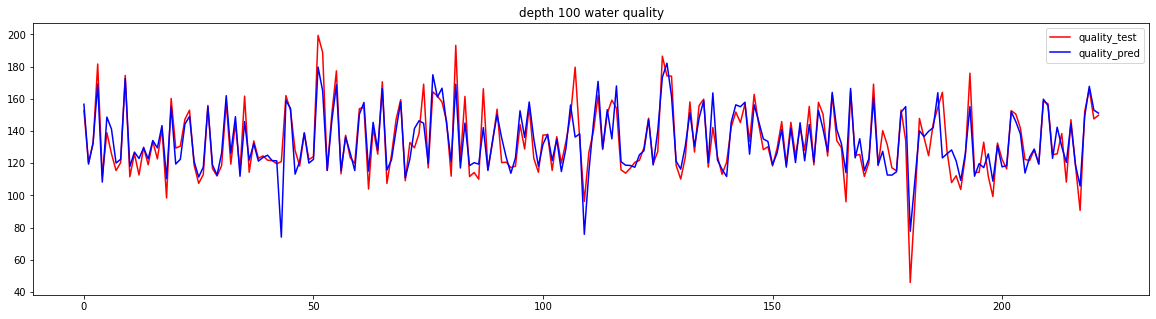

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(y_test, color='red', label='quality_test')
plt.plot(y_pred, color='blue', label='quality_pred')
plt.legend(loc="upper right")
plt.title("depth 100 water quality")
plt.show()


In [25]:
def display_qualify( y_test, y_pred):
    plt.figure(figsize=(20, 5))
    plt.plot(y_test, color='red', label='quality_test')
    plt.plot(y_pred, color='blue', label='quality_pred')
    plt.legend(loc="upper right")
    plt.title('water quality')
    plt.show()


df_depth_100
sklearn score:0.7724844950297066
Mean Absolute Error:6.82 degrees.
Accuracy:94.68 %.


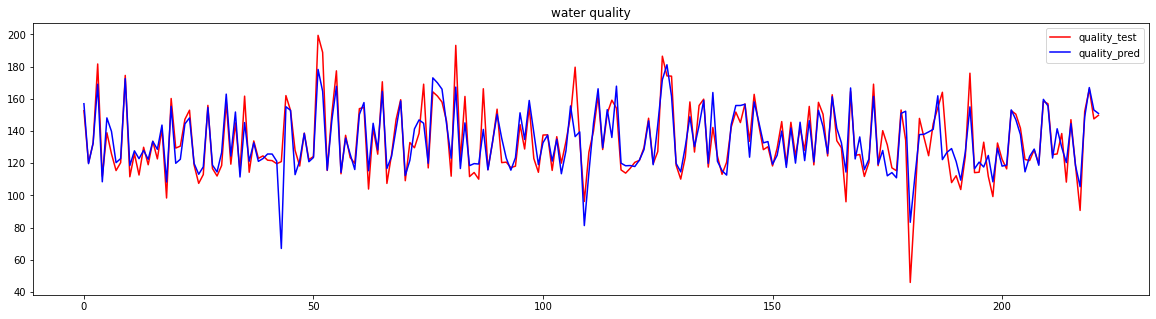

 
df_depth_500
sklearn score:0.7251265310517674
Mean Absolute Error:7.31 degrees.
Accuracy:90.39 %.


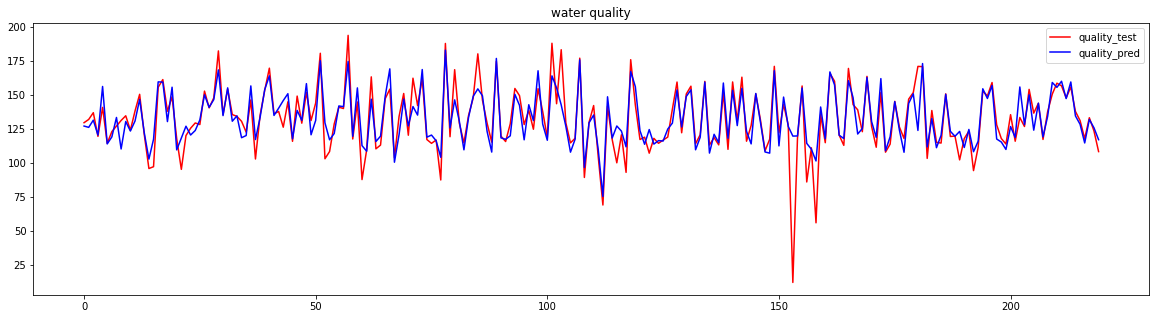

 
df_depth_1000
sklearn score:0.7842873188641393
Mean Absolute Error:9.12 degrees.
Accuracy:91.64 %.


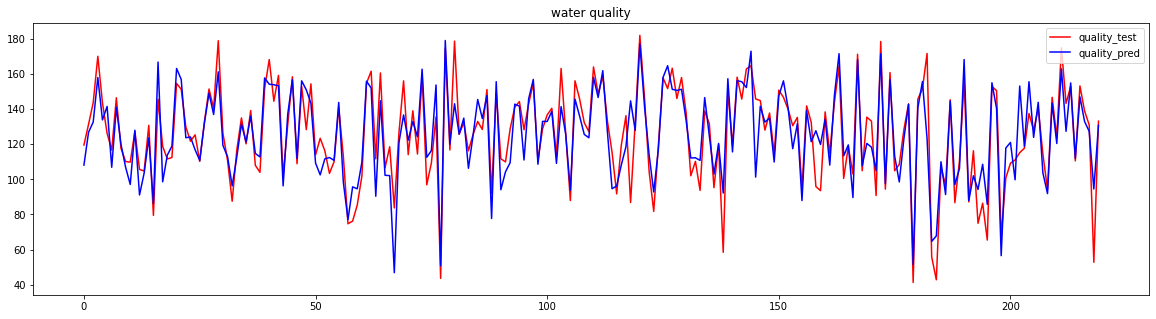

 
df_depth_1500
sklearn score:0.810233547237887
Mean Absolute Error:10.61 degrees.
Accuracy:88.14 %.


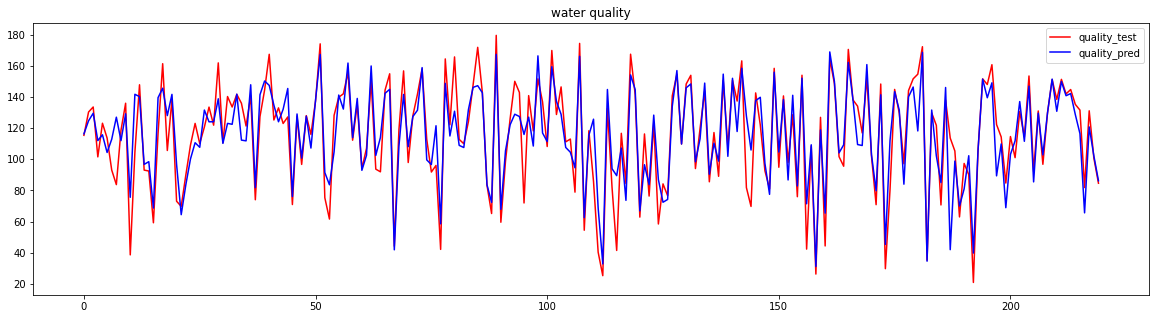

 
df_depth_2000
sklearn score:0.8072846973189084
Mean Absolute Error:13.67 degrees.
Accuracy:77.73 %.


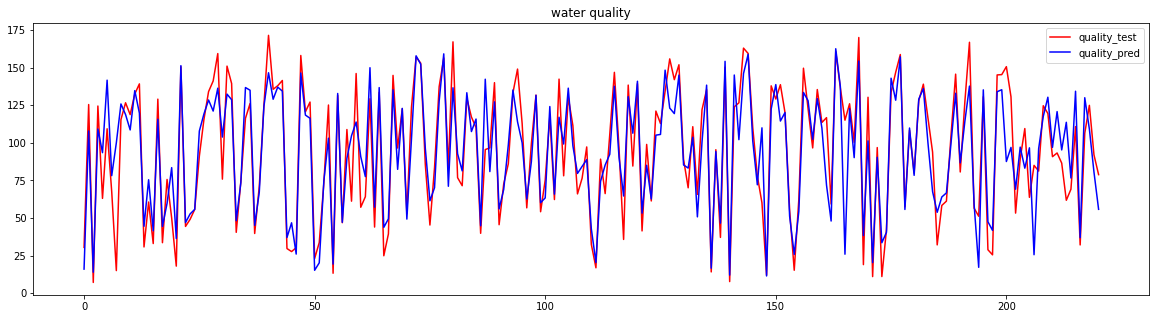

 
df_depth_2500
sklearn score:0.7843891791014859
Mean Absolute Error:15.79 degrees.
Accuracy:60.61 %.


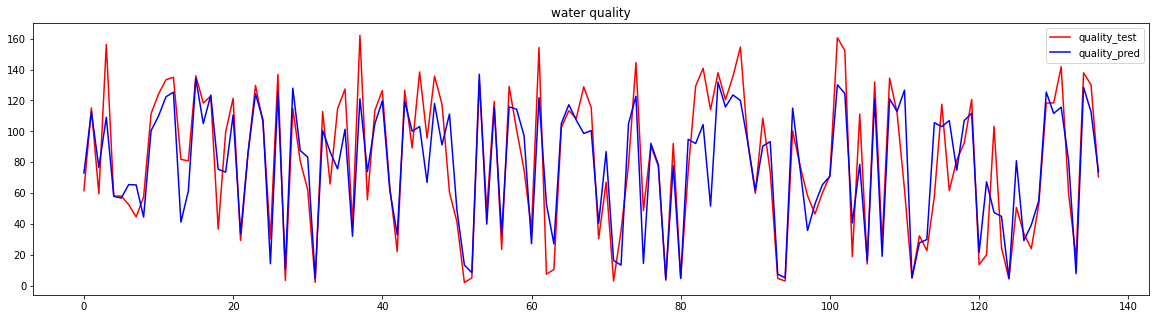

In [27]:
# by different depth

acc_list = []
for df_ in df_depth_list:
    print(df_)
    # df_ = vars()[df_]
    x_train, x_test, y_train, y_test = get_splitted_dataset(vars()[df_])
    
    # best_param = get_best_param(x_train,y_train)
    # y_pred = rfr_prediction(x_train,x_test,y_train,y_test,best_param)
    y_pred = rfr_pre(x_train,x_test,y_train,y_test)
    accuracy = error_score(y_test,y_pred)
    acc_list.append(accuracy)
    display_qualify(y_test, y_pred)
    print(' ')

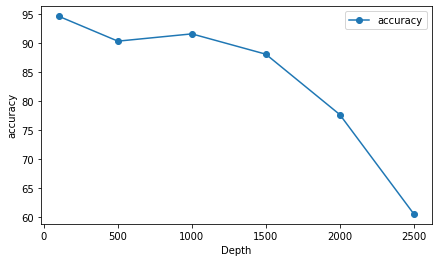

In [29]:
# 
plt.figure(figsize=(7,4))
plt.plot([depth for depth in depth_list],[acc for acc in acc_list],'o-',label="accuracy")#o-:圆形
plt.xlabel("Depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()
